# Table of contents

* [Init Colab](#scrollTo=0_init_colab)
* [DataLoaders](#scrollTo=dVX0I_3SOS1j)
    * [Images Example](#scrollTo=1_2_Images_example)
* [Basic Trainer](#scrollTo=2_Basic_Trainer)
* [Baseline](#scrollTo=3_Baseline)
    * [Baseline Model](#scrollTo=3_1_Baseline_model)
    * [Baseline Trainer](#scrollTo=3_2_Baseline_Trainer)
    * [Baseline Train and Eval](#scrollTo=3_3_Train_and_Eval)
* [Deep Domain Confusion](#scrollTo=4_Deep_Domain_Confusion)
    * [MMD Model](#scrollTo=4_1_MMD_model)
    * [MMD Trainer](#scrollTo=4_2_MMD_Trainer)
    * [MMD Train and Eval](#scrollTo=4_3_Train_and_Eval)
* [UDA by Backpropagation](#scrollTo=5_UDA_by_Backpropagation)
    * [ReverseGradient Layer](#scrollTo=5_1_ReverseGradient_Layer)
    * [Testing RevGrad](#scrollTo=5_1_1_Testing_RevGrad)
    * [RevGrad models](#scrollTo=5_2_RevGrad_models)
    * [RevGrad Trainer](#scrollTo=5_3_RevGrad_Trainer)
    * [Train and Eval](#scrollTo=5_4_Train_and_Eval)
* [DRCN](#scrollTo=6_DRCN)
    * [DRCN Model](#scrollTo=6_1_DRCN_Model)
    * [DRCN Trainer](#scrollTo=6_2_DRCN_Trainer)
    * [Train and Eval](#scrollTo=6_3_Train_and_Eval)
* [Results and Evaluation](#scrollTo=7_Results_Evaluation)
    * [Reconstructed images](#scrollTo=7_1_Reconstructed_images)
* [Utils](#scrollTo=8_Utils)

<br/>
@Gabriele Ghisleni, Data Science.
<br/>
All the experiments were monitored with wandb and visible <a href="https://wandb.ai/ggabry/UDA">here</a>.
<hr>
<br/>


# &nbsp;  0. Init Colab

Initialization of Google Colab.
<hr/>

Instruction for run the notebook:

1. Mount the drive running the cell below modifying the `folder_directory` variable with your correct path.

2. Through the usage of the `helper_dataset.ipynb` provided, extract the images in the current folder directory: `./adaptiope_small/`.  The code is present at the end of this notebook ([helper_dataset](#scrollTo=9_Helper_dataset)), is important the the datasets are available trough this path: `./adaptiope_small/`.

3. Download the `utils.py` in the current folder directory (running this cell ([utils](#scrollTo=8_Utils)) after have mounted the drive).

4. In the [Baseline Trainer](#scrollTo=3_2_Baseline_Trainer) configure properly your wandb entity.

<hr/>

In [ ]:
import sys, os, re, torch, pprint
import matplotlib.pyplot as plt
from google.colab import drive
from typing import Tuple, List
import seaborn as sns
import pandas as pd
import numpy as np
import json

# change this
folder_directory = "/content/drive/MyDrive/_____SHARED/Unsupervised-Domain-Adaptation"

drive.mount('/content/drive')
os.chdir(folder_directory)
sys.path.append(folder_directory)

pprint = pprint.PrettyPrinter(indent=4).pprint
device = torch.device('cuda')
np.random.seed(seed=42)
torch.manual_seed(42)

if torch.cuda.is_available(): 
  print(f"{'-'*100}\n{' '*25} device: {torch.cuda.get_device_name()} \n{'-'*100}")
else: print("device: CPU")


In [2]:
%%capture
!pip install wandb
import wandb; wandb.login()

# &nbsp; 1. DataLoaders

The core `UdaDataset` inherit from `torch.utils.data.Dataset` and receive two different `torchvision.datasets.ImageFolder`, one for the source domain and one that represent the target domain. 

We ensure that the images coming from the different dataset have the same shape and we iterating through it we receive a dictionary containing the source domain image, labels and target domain image and labels.

the function `create_train_test` is an utility to create the two dataset, transform them into `torch.utils.data.DataLoaders` and return them. it requires two `torch.vision.transform` to be applied respectively to the source and target domains; the test size which is by default $.2$ of the total training data and the `batch_size`.

In [3]:
# for run this cell make sure that you've created properly the utils.py
# if you mounted the drive before creating it restart first the kernel.
from utils import show_values_on_bars, create_pandas_from_wandb
from utils import show, dotdict, check_grad_names
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from typing import Callable, Tuple
import torchvision.transforms as T
import torch.nn.functional as F
import random


class UdaDataset(Dataset):
    def __init__(
        self, 
        source_domain: ImageFolder, 
        target_domain: ImageFolder, 
        verbose: bool=False
      ) -> None:
        
      self.source_domain = source_domain
      self.target_domain = target_domain
      self.mapping = self.target_domain.class_to_idx
      assert (self.source_domain[0][0].shape == self.target_domain[0][0].shape)

      if verbose:
        print(f"source_domain root: {source_domain.root}")
        print(f"target_domain root: {target_domain.root}\n")
        print(f"transform function: {source_domain.transform}\n")
        print(f"\nimages shape: {self.source_domain[0][0].shape}")

    def __getitem__(self, idx) -> dict:
      return (
          {
              'source_domain_image': self.source_domain[idx][0],
              'source_domain_label': self.source_domain[idx][1],
              'target_domain_image': self.target_domain[idx][0], 
              'target_domain_label': self.target_domain[idx][1], 
          }
      )

    def __len__(self):
        return min([len(self.source_domain), len(self.target_domain)]) -1



def create_train_test(
    test_size: float, 
    transform_source: Callable,
    return_eval_df: bool = False, 
    transform_target: (Callable or None) = None,
    source_domain_path: str = "adaptiope_small/product_images",
    target_domain_path: str = "adaptiope_small/real_life",
    batch_size: int = 32,
    print_mapping: bool = False,
  ) -> Tuple[DataLoader, DataLoader]:
  """
  Create the DataLoader classes from the two root (source and target);

  Input arguments:
      test_size: float = proportion of test size, 
      batch_size: int = 32: number of images x batch.
      return_eval_df: bool = create a third dataloader for evaluating.
      print_mapping: bool = False: to inspect the mapping of the classes.
      target_domain_path: str = "adaptiope_small/real_life": target domain root path.
      source_domain_path: str = "adaptiope_small/product_images": source domain root path.
      transform_source: Callable = torchvision transform to apply on the source domain images.
      transform_target: (Callable or None) = torchvision transform to apply on the target domain images; if None use the same as the source.

  Return:
    Tuple[DataLoader, DataLoader]

  """

  if transform_target is None:
    transform_target = transform_source

  whole_dataset = UdaDataset(
      ImageFolder(source_domain_path, transform=transform_source),
      ImageFolder(target_domain_path, transform=transform_target),
      verbose=print_mapping
      )
  
  test_range = int(len(whole_dataset) * test_size)
  train_range = int(len(whole_dataset) - test_range)

  generator = torch.Generator().manual_seed(42) # for having always the same division (ensure reproducibility)
  subsets = random_split(whole_dataset,  [train_range, test_range], generator=generator)

  if print_mapping:
      print(f"class_to_idx: ")
      pprint(whole_dataset.mapping)

  return (
          DataLoader(subsets[0], batch_size=batch_size, shuffle=True, drop_last=False,  num_workers=2, pin_memory=True),
          DataLoader(subsets[1], batch_size=batch_size, shuffle=True, drop_last=False,  num_workers=2, pin_memory=True)
          )


## &nbsp; 1.2 Images example

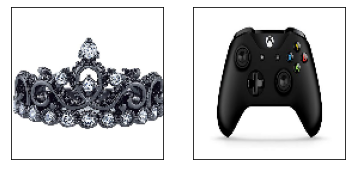

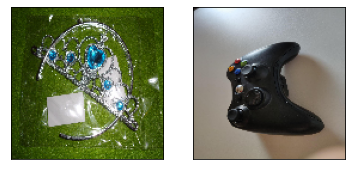

In [4]:
example_transform = T.Compose([T.ToTensor(), T.Resize(size=(128, 128))])

train, test = create_train_test(test_size=.2, 
                                transform_source=example_transform, 
                                batch_size=4, 
                                print_mapping=False)

for _, batch in (enumerate(train)):
  show(batch['source_domain_image'][:2])
  show(batch['target_domain_image'][:2])
  break

# &nbsp; 2. Basic Trainer

The BasicTrainer will be shared among all the others trainer and provide some standard functionalities.

- Provide a wrapper for logging the needed information in wandb.

- Compute the performance evaluation on the test set. This is done comparing the ground-truth and the labels prediction and taking advantage of sklearn to compute all the relevant metrics such as the overall accuracy but also the metrics for each individual class. 

- Keep track of the total test loss using a cross entropy loss.

- Provide the EarlyStopping regularization. When the metrics does not improve over a certain amount of epochs the training process is stopped by preventing overfitting on the training data. 

- Provide funcionalities for saving the relevant elements.

important: if you want to run the code change the **traininig_loop (line 85)** function according to your wandb account. 

In [5]:
from tqdm.notebook import tqdm, trange
from sklearn import metrics
from torch import Tensor
import datetime as dt
from torch import nn

class BasicTrainer:
    """
    BasicTrainer shared across all the experiments for standard functionalities

    Input arguments:
        classifier: nn.Module = nn for the classification. 
        feature_extractor: nn.Module = nn for feature extractor (if incorporate into the classifier set to None).
        patience: int = number of epochs without improving before being stopped.
        epochs: int = number of epochs to be performed.

    """

    def __init__(
        self, 
        classifier: nn.Module, 
        feature_extractor: nn.Module, 
        patience: int, 
        epochs: int, 
        **kwargs
        ) -> None:

        self.extra_saves = kwargs
        self.epochs = epochs
        self.patience = patience
        self.classifier = classifier

        self.feature_extractor = feature_extractor
        self.cross_entropy = nn.CrossEntropyLoss()
         
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

        self.classes_to_idx = { 
            'backpack': 0,
            'bookcase': 1,
            'car jack': 2,
            'comb': 3,
            'crown': 4,
            'file cabinet': 5,
            'flat iron': 6,
            'game controller': 7,
            'glasses': 8,
            'helicopter': 9,
            'ice skates': 10,
            'letter tray': 11,
            'monitor': 12,
            'mug': 13,
            'network switch': 14,
            'over-ear headphones': 15,
            'pen': 16,
            'purse': 17,
            'stand mixer': 18,
            'stroller': 19
        }

        self.idx_to_class = {v: k for k, v in self.classes_to_idx.items()}

    def training_loop(
        self, 
        training_loader: DataLoader, 
        testing_loader: DataLoader, 
        wandb_tags: list = None, 
        wandb_run_id: str = None, 
        wandb_run_name: str = None, 
        **kwargs
      ) -> None:

        """
        Wrapper function for logging into wandb the details of the experiment

        Input arguments:
            training_loader: DataLoader = dataloader used to training.
            testing_loader: DataLoader = dataloader used to testing.
            wandb_tags: list = tags to be added into the wandb run, 
            wandb_run_name: str = name of the run, 
            wandb_run_id: str = specify the id if there is the need to restore a run, 

        """

        wandb.init(
            project="UDA",
            entity="ggabry",
            config=kwargs,
            id=wandb_run_id,
            tags=wandb_tags,
            name=wandb_run_name,
            settings=wandb.Settings(symlink=False),
        )

        wandb.config.wandb_run_dir = str(wandb.run.dir).split("____SHARED")[-1]

        try: 
          self.train(training_loader, testing_loader)
        except KeyboardInterrupt: 
          print(f"Processed termined by the user at: {self.get_time()}")
        except SystemExit: 
          print(f"Processed termined by EalyStopping at: {self.get_time()}")
        finally: 
          wandb.finish()


    def validation_step(
        self, 
        batch: dict
      ) -> Tuple[Tensor, Tensor, Tensor]:
      
      """
      Extract the feature, classify and compute the cross entropy loss between
      the ground truth and the prediction.

      Input arguments:
          batch: dict = batch from custom dataloader.
        
      Return:
        Tuple[
          output: Tensor = model prediction. 
          targets: Tensor = ground truth.
          loss: Tensor = cross entropy loss.
        ]
      """
      
      image = batch["target_domain_image"].to(self.device, dtype=torch.float)
      targets = batch["target_domain_label"].to(self.device, dtype=torch.long)

      if self.feature_extractor is None:
        outputs = self.classifier(image)

      else:
        feature_map = self.feature_extractor(image)
        outputs = self.classifier(feature_map)

      loss = self.cross_entropy(outputs, targets)
      return outputs, targets, loss


    def validation(
        self, 
        testing_loader: DataLoader, 
        epoch: int
      ) -> dict:
      
      """
      Validate all the test set, compute the accuracy, store the total test loss 
      and check for the improvement in the performance; if it is the case, save the
      new model checkpoint.
      
      Input arguments:
        testing_loader: DataLoader = testing custom dataloader
        epoch: int = current epoch
        
      Return:
        dict = dictionary containing the relevant metrics.

      """

      if self.feature_extractor:
        self.feature_extractor.eval()

      self.classifier.eval()
      with torch.no_grad():
          total_test_classifer_loss, total_preds = (0, 0)
          predictions, labels = ([], [])
          progress_bar_test = tqdm(enumerate(testing_loader), leave=False, total=len(testing_loader), desc="Testing")
          for idx, data in progress_bar_test:
            outputs, targets, loss = self.validation_step(data)
            total_test_classifer_loss += loss.item()

            #class level metrics
            _, predicted = torch.max(outputs.data, axis=1)
            predictions.extend(predicted.cpu())
            labels.extend(targets.cpu())
            total_preds += targets.size(0)


      #compute metrics
      test_classifer_loss = total_test_classifer_loss / total_preds
      to_update_tqdm_bar, evals = self.compute_test_metrics(labels, predictions, 
                                                            test_classifer_loss, 
                                                            epoch)
      # check if improvement and earlystopping
      self.check_earlystopping_and_improvement(evals,
                                              test_classifer_loss, 
                                              epoch)          
      return to_update_tqdm_bar


    def compute_test_metrics(
        self, 
        labels: List[int], 
        predictions: List[int], 
        test_classifer_loss: float, 
        epoch: int
      ) -> dict:

      """
      Compute the actual metrics for the current epoch
      
      Input arguments:
        labels: List[int] = ground truth
        predictions: List[int] = model prediction
        test_classifer_loss: float = total test loss
        epoch: int = current epoch
        
      Return:
        dict = dictionary containing the relevant metrics.

      """

      target_names = [self.idx_to_class[i] for i in range(20)]
      evals = metrics.classification_report(
          labels, predictions, 
          output_dict=True, 
          zero_division=0, 
          target_names=target_names
        )

      evals["current epoch"] = epoch
      evals["total_test_loss"] = (test_classifer_loss)
      wandb.log(evals)

      to_update_tqdm_bar = dict(
          epoch = epoch,
          current_test_loss = test_classifer_loss,
          current_accuracy = evals["accuracy"],
          best_accuracy_so_far = self.best_accuracy,
          best_test_loss_so_far = self.previous_epoch_loss,  
      )
          
      return (to_update_tqdm_bar, evals)


    def check_earlystopping_and_improvement(
        self, 
        evals: dict, 
        test_classifer_loss: float, 
        epoch: int
      ) -> None:

      """
      Check if the model has improved in the during the training of the last epoch.
      If is not the case update the counter of patience and if the max patience 
      is reached stop the training process.
      
      Input arguments:
        evals: dict = metrics for the current epoch.
        test_classifer_loss: float = total test loss for the current epoch.
        epoch: int = current epoch.

      """

      # check patience reached
      if self.patience <= self.patienting:
        sys.exit()

      # looking for improvemenent
      if (
          test_classifer_loss < self.previous_epoch_loss 
          or self.best_accuracy < evals["accuracy"]
      ):
          self.patienting = 0
          self.save_models_and_params(epoch)

          #further logs and update
          if test_classifer_loss < self.previous_epoch_loss:
            self.previous_epoch_loss = test_classifer_loss
            wandb.log({'best_test_loss': self.previous_epoch_loss})

          if self.best_accuracy < evals["accuracy"]:
            self.best_accuracy = evals["accuracy"]
            wandb.log({'best_accuracy': self.best_accuracy})

      else:
        self.patienting += 1
        print(f"Skip checkpoint at  epoch {epoch} | time: {self.get_time()}")


    def save_models_and_params(
        self, 
        epoch: int
      ) -> None:

      """
      Save the model and all the relevant objects.       
      
      Input arguments:
        epoch: int = current epoch.

      """

      re_training_params = dict(
          classifier = self.classifier.state_dict(),
          feature_extractor = self.feature_extractor.state_dict() if self.feature_extractor else None,
          epoch = epoch
      )

      for extra_save, extra_value in self.extra_saves.items():
        re_training_params[extra_save] = extra_value.state_dict()

      torch.save(re_training_params, os.path.join(wandb.run.dir, f"{self.classifier.name}-re_train_args.pt"))
      wandb.save(f"{self.classifier.name}-re_train_args.pt")
      print(f"End of epoch: {epoch} | Saving checkpoint | at {self.get_time()}")


    def get_time(self):
      return dt.datetime.now().strftime('%H:%M:%S')


# &nbsp; 3. Baseline 

## &nbsp; 3.1 Baseline model

Use a pretrained ResNet50 as backbone and a traditional classification head.

1.  Feature extractor (obtained by replacing the original classification head of the pretrained resnet into an Identity).

2. Custom classification head (Dropout + Linear layer).

Using this approach we are able to decouple the feature map from the classification itself and doing this we can return from the forward function both the feature map extracted from the image and the logits from the classification. 

In [ ]:
from torchvision import models
import torch.nn as nn

class FeatureExtractorResNet(nn.Module):
  "backbone feature extractor"

  def __init__(self):
      super().__init__()
      self.feature_extractor = models.resnet50(pretrained=True)
      self.feature_extractor.fc = nn.Identity()
      self.name = "FeatureExtractor"
      self.to(
            torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
      )
      
  def forward(self, x):
    feature_map = self.feature_extractor(x)
    return feature_map


class BaseLineClassifer(nn.Module):
  """
  Baseline classifier composed by a simple Linear Layer with Dropout.

  Input arguments:
      dropout: float (.15) = probability of dropout.
      in_features_head: int (2048) = number of features from the feature extractor.
      num_classes: int (20) = dimension of final output.

  """

  def __init__(
      self, 
      dropout: float =.15,
      in_features_head: int = 2048,
      num_classes: int = 20
      ) -> None:

      super().__init__()

      self.classifier = nn.Sequential(
          nn.Dropout(dropout),
          nn.Linear(in_features_head, num_classes)
      )

      self.name = "BaseLineClassifier"
      self.to(
            torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
      )

  def forward(self, x):
    output = self.classifier(x)
    return output
      
_ = FeatureExtractorResNet()

## &nbsp; 3.2 Baseline Trainer

The BaselineTrainer will just train the model on the source domain and evaluate it on the target domain.

- The classification step is made using the cross entropy loss only working with the source domain images. 

- We used `Adam` optimizer and the `ExponentialLR` for handling the learning while training.  

In [7]:
class BaselineTrainer(BasicTrainer):
  """
  Baseline trainer.

  Input arguments:
      classifier: nn.Module = nn for the classification. 
      feature_extractor: nn.Module = nn for feature extractor (if incorporate into the classifier set to None).
      optimizer: torch.optim.Optimizer = optimizer for training the model.
      scheduler: torch.optim.lr_scheduler.ExponentialLR = scheduler for shrinking the lr during the training.
      patience: int = number of epochs without improving before being stopped.
      epochs: int = number of epochs to be performed.

  """
  
  def __init__(
      self, 
      classifier: nn.Module, 
      feature_extractor: nn.Module, 
      optimizer: torch.optim.Optimizer, 
      scheduler: torch.optim.lr_scheduler.ExponentialLR, 
      patience: int, 
      epochs: int
    ) -> None:

    self.optimizer = optimizer
    self.scheduler = scheduler

    self.extra_saves = dict(
      classifier=classifier,
      feature_extractor=feature_extractor,
      optimizer=optimizer,
      scheduler=scheduler    
    )

    super().__init__(patience=patience, epochs=epochs, **self.extra_saves)
  
  def classifier_step(
      self, 
      batch: dict
    ) -> dict:

    """
    Classification step performed on the source domain. 
    
    Input arguments:
      batch: dict = batch from custom dataloaders.

    Return:
      dict = cross entropy loss between the prediction and the ground truth.
    """
    
    image = batch["source_domain_image"].to(self.device, dtype=torch.float)
    targets = batch["source_domain_label"].to(self.device, dtype=torch.long)
    feature_map = self.feature_extractor(image)
    outputs = self.classifier(feature_map)
    return self.cross_entropy(outputs, targets)

  def train(
      self, 
      training_loader: DataLoader, 
      testing_loader: DataLoader
      ) -> None:

      progress_bar_epoch = trange(1, self.epochs, leave=True, desc="Epoch")
      self.patienting = 0
      self.best_accuracy = 0 
      self.previous_epoch_loss = 1e5

      for epoch in progress_bar_epoch:
          self.feature_extractor.train()
          self.classifier.train()
          total_train_classifier_loss, n_samples = 0, 0
          progress_bar_batch = tqdm(enumerate(training_loader), leave=False, total=len(training_loader), desc="Training")

          for idx, data in progress_bar_batch:
              self.optimizer.zero_grad()
              loss = self.classifier_step(data)
              loss.backward()
              self.optimizer.step()

              total_train_classifier_loss += loss.item()
              n_samples += data["source_domain_image"].size(0)

              if (idx % 5 == 0 and idx):
                  progress_bar_batch.set_postfix({"classifier_loss": total_train_classifier_loss/n_samples})

          if self.scheduler:
            self.scheduler.step()
            
          wandb.log({"classifier_loss": total_train_classifier_loss/n_samples}, commit=False)
          validation_metrics = self.validation(testing_loader, epoch)
          progress_bar_epoch.set_postfix(validation_metrics)

## &nbsp; 3.3 Train and Eval

Regarding the hyperparameters here we made several trial and error; 

- We used the learning rate of the backbone (ResNet) quite low ($1^{e-5}$ to $5^{e-5}$) while the classifier learning rate by an order of magnitude.

- For the optimizer we always relied on the `Adam` optimizer and the `ExponentialLR` for shrinking the lr while training. 

- We create a `torch.vision.transform` for preparing and slightly change the input image (only source domain) adding a small amount of padding, resizing the image, add a random perspective with a probability of $.8$ and transform  it to a `torch.tensor`.



In [8]:
#################################################################################################
config = dotdict({
    'lr_classifier': .0005,
    'lr_backbone': .00001,
    'weight_decay': 0.05,
    'optimizer': 'adam',
    'batch_size': 64,
    'backbone':'resnet50',
    'scheduler': 'exponential',
    'gamma': .96,
})

config.print_all()

#################################################################################################

transform_source = T.Compose([
    T.Pad(padding=10),
    T.Resize(size=(256, 256)),
    T.RandomPerspective(distortion_scale=0.3, p=.8),
    T.ToTensor(),
  ])

transform_target = T.Compose([T.ToTensor(), T.Resize(size=(256, 256))])
config.transform_source = transform_source.__str__()
config.transform_target = transform_target.__str__()

source, target = "adaptiope_small/product_images", "adaptiope_small/real_life"
direction = f"{source.split('/')[1][0]} to {target.split('/')[1][0]}"

train, test = create_train_test(test_size=.2, 
                                source_domain_path=source,
                                target_domain_path=target,      
                                transform_source=transform_source, 
                                transform_target=transform_target,
                                batch_size=config.batch_size)

#################################################################################################

classifier = BaseLineClassifer()
feature_extractor = FeatureExtractorResNet()

#################################################################################################

params = [{'params': feature_extractor.parameters(), 'lr': config.lr_backbone}, 
          {'params': classifier.parameters(),'lr': config.lr_classifier}]

optimizer = torch.optim.Adam(params, weight_decay=config.weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=config.gamma)

#################################################################################################

trial = BaselineTrainer(
  classifier=classifier,
  feature_extractor=feature_extractor,
  optimizer=optimizer,
  scheduler=scheduler,
  patience=25,
  epochs=100
)

print("-"*150);print(classifier);print("-"*150)
# check_grad_names(feature_extractor);print("-"*150);
check_grad_names(classifier);print("-"*150);

{   'backbone': 'resnet50',
    'batch_size': 64,
    'gamma': 0.96,
    'lr_backbone': 1e-05,
    'lr_classifier': 0.0005,
    'optimizer': 'adam',
    'scheduler': 'exponential',
    'weight_decay': 0.05}
------------------------------------------------------------------------------------------------------------------------------------------------------
BaseLineClassifer(
  (classifier): Sequential(
    (0): Dropout(p=0.15, inplace=False)
    (1): Linear(in_features=2048, out_features=20, bias=True)
  )
)
------------------------------------------------------------------------------------------------------------------------------------------------------
BaseLineClassifier
Layer with gradients active:	 classifier.1.weight
Layer with gradients active:	 classifier.1.bias
------------------------------------------------------------------------------------------------------------------------------------------------------


In [9]:
# trial.training_loop(train, test, wandb_run_name="baseline_v1", wandb_tags=['baseline', direction], **config)

# &nbsp; 4 Deep Domain Confusion
Maximizing for Domain Invariance
- paper https://arxiv.org/pdf/1412.3474.pdf.

Directly training a classifier using only the source data
often leads to overfitting to the source distribution, causing
reduced performance at test time when recognizing in the
target domain. **Our intuition is that if we can learn a representation that minimizes the distance between the source
and target distributions**, then we can train a classifier on the
source labeled data and directly apply it to the target domain
with minimal loss in accuracy.

To minimize this distance, we consider the standard
distribution distance metric, Maximum Mean Discrepancy
(MMD) [6].  not only do we want to minimize the
distance between domains (or maximize the domain confusion), but we want a representation which is conducive to
training strong classifiers.

One approach to meeting both these criteria is to
minimize the loss:

$$L= L_{c}(X_{L}, y) + \lambda MMD^{2}(X_{s}, X_{t})$$


**where $L_{c}(X_{L}, y)$ denotes classification loss** on the available labeled data, $X_{L}$, and the ground truth labels, y, and **MMD$^{2}(X_{s}, X_{t})$ denotes the distance between the source
data, $X_{s}$, and the target data, $X_{t}$**. The hyperparameter $\lambda$
determines how strongly we would like to confuse the domains.

We begin with the Krizhevsky architecture [24], which
has five convolutional and pooling layers and *three fully
connected layers with dimensions {4096, 4096, |C|}.* **We
additionally add a lower dimensional, “bottleneck,” adaptation layer.** Our intuition is that a lower dimensional layer
can be used to regularize the training of the source classifier and prevent overfitting to the particular nuances of the
source distribution. **We place the domain distance loss on
top of the “bottleneck” layer to directly regularize the representation to be invariant to the source and target domains.**

( We set the regularization hyperparameter to
$\lambda$ = 0.25, which makes the objective primarily weighted towards classification, but with enough regularization to avoid
overfitting)

![MDD](https://raw.githubusercontent.com/GabrieleGhisleni/Unsupervised-domain-adaptation/master/images/mmd.png)

useful links:
6) K. M. Borgwardt, A. Gretton, M. J. Rasch, H.-P. Kriegel,
B. Scholkopf, and A. J. Smola. Integrating structured biolog- ¨
ical data by kernel maximum mean discrepancy. In Bioinformatics, 2006.

24) A. Krizhevsky, I. Sutskever, and G. E. Hinton. ImageNet
classification with deep convolutional neural networks. In
Proc. NIPS, 2012. 2, 3

<hr><br/>

**The Maximum Mean Discrepancy (MMD)** is a measure of the distance between the distributions of prediction scores on two groups of examples. The metric guarantees that the result is 0 if and only if the two distributions it is comparing are exactly the same. The `membership` input indicates with a numerical value whether each example is part of the sensitive group with a numerical value. This currently only supports hard membership of `0.0` or `1.0`. For more details, see the [paper](http://papers.nips.cc/paper/3110-a-kernel-method-for-the-two-sample-problem.pdf).

implementation found here:
- https://www.kaggle.com/code/onurtunali/maximum-mean-discrepancy/notebook
```python
  def MMD(self, x, y, kernel="multiscale"):
      """
      # https://www.kaggle.com/code/onurtunali/maximum-mean-discrepancy/notebook
      Emprical maximum mean discrepancy. The lower the result, the more evidence that distributions are the same.
      """
      xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
      rx = (xx.diag().unsqueeze(0).expand_as(xx))
      ry = (yy.diag().unsqueeze(0).expand_as(yy))
      
      dxx = rx.t() + rx - 2. * xx # Used for A in (1)
      dyy = ry.t() + ry - 2. * yy # Used for B in (1)
      dxy = rx.t() + ry - 2. * zz # Used for C in (1)
      
      XX, YY, XY = (torch.zeros(xx.shape).to(device),
                    torch.zeros(xx.shape).to(device),
                    torch.zeros(xx.shape).to(device))
      
      if kernel == "multiscale":
          bandwidth_range = [0.2, 0.5, 0.9, 1.3]
          for a in bandwidth_range:
              XX += a**2 * (a**2 + dxx)**-1
              YY += a**2 * (a**2 + dyy)**-1
              XY += a**2 * (a**2 + dxy)**-1
              
      if kernel == "rbf":
          bandwidth_range = [10, 15, 20, 50]
          for a in bandwidth_range:
              XX += torch.exp(-0.5*dxx/a)
              YY += torch.exp(-0.5*dyy/a)
              XY += torch.exp(-0.5*dxy/a)
  
      return torch.mean(XX + YY - 2. * XY)
```


## &nbsp; 4.1 MMD model

Use a pretrained ResNet50 as backbone adding more Linear Layers (along with Dropout and ReLU) and a traditional classification head.

1.  Feature extractor (obtained by replacing the original classification head of the pretrained resnet into an Identity) and adding three fully connected  layers of \{2056, 2056, 512} with Dropout and ReLU. We have performed the MMD comparison  on the second-last layer (512) and because of that we have tried also to change the activation function from ReLU to Sigmoid.

2. Custom classification head (Dropout + Linear layer \{512 , n_classes}.


In [10]:
from torchvision import models
import torch.nn as nn


class BottleNeckFeatureExtractor(nn.Module):
    """
    On the original paper they have used a CNN + three fully connected layers of 4096, 
    4096, n_classes ad added a lower dimensional 'bottleneck', adaptation layer.
    Here we used a ResNet + FFL {2056, 2056, 512, n_classes} and we will compute
    the MMD on the output of the 512 layer.
    
    Input arguments:
      dropout: float (.15) = probability of dropout.
      out_dim: int (512) = feature dimension out.
    """

    def __init__(
          self, 
          dropout: float = .15, 
          out_dim: int = 512
        ) -> None:

        super().__init__()
        self.feature_extractor = models.resnet50(pretrained=True)
        in_features_head = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = nn.Identity()

        # heavy linear layers 
        self.dense_layer = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features_head, in_features_head), 
            nn.Dropout(dropout), 
            nn.ReLU(),
            nn.Linear(in_features_head, in_features_head),
            nn.Dropout(dropout), 
            nn.ReLU(),
        )

        # bottle neck linear layers 
        self.bottle_neck = nn.Sequential(
            nn.Linear(in_features_head, out_dim), 
            nn.Dropout(dropout), 
            # nn.Tanh(), trial
            nn.ReLU(),
        )
        self.name = "BottleNeckFeatureExtractor"
        self.to(
              torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        )
        
    def forward(self, x):
      feature_map = self.feature_extractor(x)
      dense_representation = self.dense_layer(feature_map)
      shrinked_feature_map = self.bottle_neck(dense_representation)
      return shrinked_feature_map


class MMDClassifer(nn.Module):
    """
    MMD classification headclassifier composed by a simple Linear Layer.
    the features that comes in are already passed through an activation function.

    Input arguments:
        dropout: float (.15) = probability of dropout.
        out_dim: int (512) = feature in from the feature_extractor.
        num_classes: int (20) = dimension of final output.
    """

    def __init__(
          self, 
          dropout: float = .15, 
          out_dim: int = 512, 
          num_classes: int = 20
        ) -> None:

        super().__init__()

        self.classifier_head = nn.Linear(out_dim, num_classes)
        self.name = "MMDClassifer"
        self.to(
              torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        )

    def forward(self, shrinked_feature_map):
      output = self.classifier_head(shrinked_feature_map)
      return output

_ = MMDClassifer()

## &nbsp; 4.2 MMD Trainer

The MMDTrainer takes in count the loss derived from the traditional classification step on the source domain dataset and add a further loss: the `mmd_loss`, which represents how much two very high distribution differs (regularized by an hyperparameter `mmd_lambda`).

- The classification step is made using the cross entropy loss only working with the source domain images. 

- We used `Adam` optimizer and the `ExponentialLR` for handling the learning while training.  

- Regarding the kernel parameter for the mmd function represent a variation of how it is computed (since we were not able to properly understand the advantages and disadvantages we always use the default `multiscale`.

- the `mmd_loss` is computed on the latent feature representation of the source and domain images and weighted by an hyperparameter `mmd_lambda`)

In [11]:
class MMDTrainer(BasicTrainer):
  """
  MMD trainer.

  Input arguments:
      classifier: nn.Module = nn for the classification. 
      feature_extractor: nn.Module = nn for feature extractor (if incorporate into the classifier set to None).
      optimizer: torch.optim.Optimizer = optimizer for training the model.
      scheduler: torch.optim.lr_scheduler.ExponentialLR = scheduler for shrinking the lr during the training.
      patience: int = number of epochs without improving before being stopped.
      epochs: int = number of epochs to be performed.
      mmd_lambda: float (.25) = parameter to regulate the tradeoff between classification and mmd loss.
      kernel: str ("multiscale") = kernel used for mmd.

  """

  def __init__(
      self, 
      classifier: nn.Module, 
      feature_extractor: nn.Module, 
      optimizer: torch.optim.Optimizer, 
      scheduler: torch.optim.lr_scheduler.ExponentialLR, 
      patience: int, 
      epochs: int, 
      mmd_lambda: float = .25, 
      kernel: str = "multiscale"
      ) -> None:

    self.optimizer = optimizer
    self.scheduler = scheduler
    self.mmd_lambda = mmd_lambda
    self.kernel = kernel

    self.extra_saves = dict(
      classifier=classifier,
      feature_extractor=feature_extractor,
      optimizer=optimizer,
      scheduler=scheduler    
    )

    super().__init__(patience=patience, epochs=epochs, **self.extra_saves)
  

  def classifier_step(
      self, 
      shrinked_feature_map_source, 
      labels
    ) -> Tensor:

    outputs = self.classifier(shrinked_feature_map_source)
    classifier_loss = self.cross_entropy(outputs, labels)
    return classifier_loss


  def train(
      self, 
      training_loader: DataLoader, 
      testing_loader: DataLoader
      ) -> None:

      progress_bar_epoch = trange(1, self.epochs, leave=True, desc="Epoch")
      self.patienting = 0
      self.best_accuracy = 0 
      self.previous_epoch_loss = 1e5

      for epoch in progress_bar_epoch:
          self.classifier.train()
          self.feature_extractor.train()
          total_classifier_loss, mmd_total_loss, n_samples = 0, 0, 0
          progress_bar_batch = tqdm(enumerate(training_loader), leave=False, total=len(training_loader), desc="Training")

          for idx, data in progress_bar_batch:
              self.optimizer.zero_grad()

              source_images = data["source_domain_image"].to(self.device, dtype=torch.float)
              target_images = data["target_domain_image"].to(self.device, dtype=torch.float)
              labels = data["source_domain_label"].to(self.device, dtype=torch.long)

              # mmd step
              shrinked_feature_map_source = self.feature_extractor(source_images)
              shrinked_feature_map_target = self.feature_extractor(target_images)

              mmd_loss = self.maximum_mean_discrepancies(
                    shrinked_feature_map_source, 
                    shrinked_feature_map_target, 
                    self.kernel
                  )
              
              mmd_loss_adjusted = (self.mmd_lambda * mmd_loss)
              
              classification_loss = self.classifier_step(shrinked_feature_map_source, labels)

              loss = classification_loss + mmd_loss_adjusted
              loss.backward()
              self.optimizer.step()

              total_classifier_loss += classification_loss.item()
              mmd_total_loss += mmd_loss.item()
              n_samples += data["source_domain_image"].size()[0]

              loss_progress = {
                  "classifier_loss": total_classifier_loss/n_samples, 
                  "mmd_loss": mmd_total_loss/n_samples,
                  "total_loss": (total_classifier_loss+mmd_total_loss)/n_samples
                  }

              if (idx % 2 == 0 and idx):
                progress_bar_batch.set_postfix(loss_progress)

          if self.scheduler:
            self.scheduler.step()

          wandb.log(loss_progress, commit=False)
          validation_metrics = self.validation(testing_loader, epoch)
          progress_bar_epoch.set_postfix(validation_metrics)


  def maximum_mean_discrepancies(self, x, y, kernel="multiscale"):
      """
      # https://www.kaggle.com/code/onurtunali/maximum-mean-discrepancy/notebook
      Emprical maximum mean discrepancy. The lower the result, the more evidence that distributions are the same.
      """
      xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
      rx = (xx.diag().unsqueeze(0).expand_as(xx))
      ry = (yy.diag().unsqueeze(0).expand_as(yy))
      
      dxx = rx.t() + rx - 2. * xx # Used for A in (1)
      dyy = ry.t() + ry - 2. * yy # Used for B in (1)
      dxy = rx.t() + ry - 2. * zz # Used for C in (1)
      
      XX, YY, XY = (torch.zeros(xx.shape).to(device),
                    torch.zeros(xx.shape).to(device),
                    torch.zeros(xx.shape).to(device))
      
      if kernel == "multiscale":
          bandwidth_range = [0.2, 0.5, 0.9, 1.3]
          for a in bandwidth_range:
              XX += a**2 * (a**2 + dxx)**-1
              YY += a**2 * (a**2 + dyy)**-1
              XY += a**2 * (a**2 + dxy)**-1
              
      if kernel == "rbf":
          bandwidth_range = [10, 15, 20, 50]
          for a in bandwidth_range:
              XX += torch.exp(-0.5*dxx/a)
              YY += torch.exp(-0.5*dyy/a)
              XY += torch.exp(-0.5*dxy/a)
  
      return torch.mean(XX + YY - 2. * XY)

## &nbsp; 4.3 Train and Eval

Regarding the hyperparameters here we made several trial and error; 

- We used the learning rate of the backbone (ResNet) higher compared to the baseline($1^{e-4}$ to $5^{e-5}$) while the classifier learning rate by an order of magnitude.

- Regarding the mmd loss hyperparameters, we relied completely  on the default `multiscale` kernel and we tried different values for the `mmd_lambda` from $.75$ to $1$.

- For the optimizer we always relied on the `Adam` optimizer and the `ExponentialLR` for shrinking the lr while training. 

- We create a `torch.vision.transform` for preparing and slightly change the input image (only source domain) adding a small amount of padding, resizing the image, add a random perspective with a probability of $.8$ and transform  it to a `torch.tensor`.






In [12]:
#################################################################################################
config = dotdict({
    'optimizer': 'adam',
    'lr_classifier': .0005,
    'lr_backbone': .0001,
    'weight_decay': 0.02,
    'scheduler': 'exponential',
    'gamma': .96,
    'batch_size': 32,
    'backbone':'resnet50',
    'mmd_lambda': .75,
    'kernel':'multiscale'
})

print("-"*150);
config.print_all()

#################################################################################################

transform_source = T.Compose([
    T.Pad(padding=10),
    T.Resize(size=(256, 256)),
    T.RandomPerspective(distortion_scale=0.3, p=.8),
    T.ToTensor(),
  ])


transform_target = T.Compose([T.ToTensor(), T.Resize(size=(256, 256))])
config.transform_source = transform_source.__str__()
config.transform_target = transform_target.__str__()

target, source = "adaptiope_small/product_images", "adaptiope_small/real_life"
direction = f"{source.split('/')[1][0]} to {target.split('/')[1][0]}"

train, test = create_train_test(test_size=.2, 
                                source_domain_path=source,
                                target_domain_path=target,      
                                transform_source=transform_source, 
                                transform_target=transform_target,
                                batch_size=config.batch_size)

#################################################################################################

classifier = MMDClassifer()
feature_extractor = BottleNeckFeatureExtractor()

#################################################################################################

params = [{'params': feature_extractor.parameters(), 'lr': config.lr_backbone}, 
          {'params': classifier.parameters(),'lr': config.lr_classifier}]

optimizer = torch.optim.Adam(params, weight_decay=config.weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=config.gamma)

#################################################################################################

trial = MMDTrainer(
  feature_extractor=feature_extractor,
  classifier=classifier,
  mmd_lambda=config.mmd_lambda,
  kernel=config.kernel,
  optimizer=optimizer,
  scheduler=scheduler,
  patience=25,
  epochs=100
)

print("-"*150);print(classifier);print("-"*150)
print("-"*150);print("dense_layer\n");print(feature_extractor.dense_layer);print("-"*150)
print("-"*150);print("bottle_neck\n");print(feature_extractor.bottle_neck);print("-"*150)
# check_grad_names(feature_extractor);print("-"*150);
check_grad_names(classifier);print("-"*150);


------------------------------------------------------------------------------------------------------------------------------------------------------
{   'backbone': 'resnet50',
    'batch_size': 32,
    'gamma': 0.96,
    'kernel': 'multiscale',
    'lr_backbone': 0.0001,
    'lr_classifier': 0.0005,
    'mmd_lambda': 0.75,
    'optimizer': 'adam',
    'scheduler': 'exponential',
    'weight_decay': 0.02}
------------------------------------------------------------------------------------------------------------------------------------------------------
MMDClassifer(
  (classifier_head): Linear(in_features=512, out_features=20, bias=True)
)
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
dense_layer

Sequential(
  (0): Dropout(p=0.15,

In [13]:
# trial.training_loop(test, test, wandb_run_name="mmd_v1", wandb_tags=['mmd', config.kernel, direction], **config)

#  &nbsp; 5 UDA by Backpropagation
Unsupervised Domain Adaptation by Backpropagation

- paper: (https://arxiv.org/pdf/1409.7495.pdf)

the approach promotes the emergence of “deep” features that are (i) discriminative for the main learning task on the source domain and (ii) invariant with respect to the shift between the domains. We show that this adaptation behaviour can be achieved in almost any feed-forward model by augmenting it with few standard layers and a simple new **gradient reversal layer**. The resulting augmented architecture can be trained using standard backpropagation.

we focus on combining domain adaptation and deep feature learning within one training process (deep domain adaptation). Our goal is to embed domain adaptation into the process of learning representation, so that the final classification decisions are made based on features that are both discriminative and invariant to the change of domains, i.e. have the same or very similar distributions in the source and the target domains.

We thus focus on learning features that combine (i) discriminativeness and (ii) domain-invariance. This is achieved by jointly optimizing the underlying features as well as **two discriminative classifiers** operating on these features: (i) the **label predictor** that predicts class labels and is used both during training and at test time and (ii) the **domain classifier** that discriminates between the source and the target domains during training. While the parameters of the classifiers are optimized in order to minimize their error on the training set, **the parameters of the underlying deep feature mapping are optimized in order to minimize the loss of the label classifier and to maximize the loss of the domain classifier.**

 In practice, the only non-standard component of the proposed architecture is a rather trivial gradient reversal layer that leaves the input unchanged during forward propagation and reverses the gradient by multiplying it by a negative scalar during the backpropagation.

![Architecture](https://raw.githubusercontent.com/GabrieleGhisleni/Unsupervised-domain-adaptation/master/images/gradient_reversal_layer.png) 

We now define a deep feed-forward architecture that for each input x predicts its label $y \in Y$ and its domain label $d \in \{0,1\}$. We decompose such mapping into three parts. We assume that the input x is first mapped by a mapping $G_{f}$ (a feature extractor) to a D-dimensional feature vector $f \in R^{d}$. The feature mapping may also include several feed-forward layers and we denote the vector of parameters of all layers in this mapping as $\theta_{f}$ , i.e. $f = G_{f}(x, \theta_{f})$. Then, the feature vector f is mapped by a mapping $G_{y}$ (label predictor) to the label y, and we denote the parameters of this mapping with $\theta_{y}$ . Finally, the same feature vector f is mapped to the domain label $d$ by a mapping $G_{d}$ (domain classifier) with the parameters $\theta_{d}$.

Measuring the dissimilarity of the distributions $S_{f}$ and $T_{f}$ is however non-trivial, given that f is high-dimensional, and that the distributions themselves are constantly changing as learning progresses. One way to estimate the dissimilarity is to look at the loss of the domain classifier $G_{d}$, provided that the parameters $\theta_{d}$ of the domain classifier have been trained to discriminate between the two feature distributions in an optimal way. 

This observation leads to our idea. At training time, in order to obtain domain-invariant features, **we seek the parameters $\theta_{f}$ of the feature mapping that maximize the loss of the domain classifier (by making the two feature distributions as similar as possible), while simultaneously seeking the parameters $\theta_{d}$ of the domain classifier that minimize the loss of the domain classifier. In addition, we seek to minimize the loss of the label predictor.**

The parameter $\lambda$ controls the trade-off
between the two objectives that shape the features during
learnin.

y introducing a special gradient reversal layer (GRL) defined as
follows. The gradient reversal layer has no parameters associated with it (apart from the meta-parameter  $\lambda$, which
is not updated by backpropagation). During the forward
propagation, GRL acts as an identity transform. During
the backpropagation though, GRL takes the gradient from
the subsequent level, multiplies it by − $\lambda$ and passes it to
the preceding layer. Implementing such layer using existing object-oriented packages for deep learning is simple, as
defining procedures for forwardprop (identity transform),
backprop (multiplying by a constant), and parameter update (nothing) is trivial

## &nbsp; 5.1 ReverseGradient Layer

Create a custom hook for gradient reversal layer.

In [14]:
# https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function
# https://discuss.pytorch.org/t/gradient-reversal-domain-adapation-not-converging-always/11327/2
# https://github.com/jvanvugt/pytorch-domain-adaptation/blob/master/utils.py
# https://github.com/janfreyberg/pytorch-revgrad

class GradientReversalF(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x, alpha):
    "let the input unchaged"
    ctx.save_for_backward(alpha)
    return x

  @staticmethod
  def backward(ctx, grad_output):
    "reverse the gradient by multipling -alpha"  
    alpha = ctx.saved_tensors[0]
    if ctx.needs_input_grad[0]:
      grad_output = (grad_output * (-alpha))
    return (grad_output, None)


class GradientReverse(nn.Module):
  def __init__(self, alpha, *args, **kwargs):
    "Reverse GR layer hook"
    super().__init__(*args, **kwargs)
    self.alpha = torch.tensor(alpha, requires_grad=False)
    assert alpha > 0, 'alpha must be > 0'
    print(f"The gradient will be multiplied by: {-alpha}")

  def forward(self, x):
    return GradientReversalF.apply(x, self.alpha)


### &nbsp; 5.1.1 Testing RevGrad

In [15]:
import copy

def test_grad_reverese(alpha):
    criterion = torch.nn.MSELoss()
    input, output = torch.randn(8, 5), torch.randn(8, 1)

    network = nn.Sequential(nn.Linear(5, 1), torch.nn.Linear(1, 1))
    revnetwork = nn.Sequential(
        copy.deepcopy(network), 
        GradientReverse(alpha),
        )

    criterion(network(input), output).backward()
    criterion(revnetwork(input), output).backward()

    for p1, p2 in zip(network.parameters(), revnetwork.parameters()):
      print("-"*100)
      print(f"original: {p1.grad}")
      print(f"reversed: {p2.grad/alpha}")
      assert torch.isclose(p1.grad, ((-p2.grad)/alpha)).all()
    print("-"*100)

test_grad_reverese(1)

The gradient will be multiplied by: -1
----------------------------------------------------------------------------------------------------
original: tensor([[-0.1197,  1.3743, -3.2161, -0.3826, -0.4297]])
reversed: tensor([[ 0.1197, -1.3743,  3.2161,  0.3826,  0.4297]])
----------------------------------------------------------------------------------------------------
original: tensor([-2.0040])
reversed: tensor([2.0040])
----------------------------------------------------------------------------------------------------
original: tensor([[2.3353]])
reversed: tensor([[-2.3353]])
----------------------------------------------------------------------------------------------------
original: tensor([-2.1603])
reversed: tensor([2.1603])
----------------------------------------------------------------------------------------------------


## &nbsp; 5.2 RevGrad models

Use a pretrained ResNet50 as backbone, a custom classification head compose by Linear Layers (along with Dropout and ReLU) and a discriminator (source vs target domain) with a GradientReversal Layer.

1.  Feature extractor (obtained by replacing the original classification head of the pretrained resnet into an Identity) 

2. Custom classification head composed by three fully connected  layers of \{2056, 2056, 512, n_classes} with Dropout and ReLU.

3. Discriminator classifier composed by a GradientReversal layer for invert the gradient and two Linear Layers (with ReLU and Dropout).


In [16]:
class FeatureExtractorResNet(nn.Module):
    "Basic ResNet as backbone for feature extraction"

    def __init__(self):
      super().__init__()
      self.feature_extractor = models.resnet50(pretrained=True)
      self.feature_extractor.fc = nn.Identity()

      self.name = "FeatureExtractor"
      self.to(
            torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
      )   

    def forward(self, x):
      feature_map = self.feature_extractor(x)
      return feature_map


class RevGradClassifer(nn.Module):
    """
    Reversal gradient classification head composed by 4 linear layer 
    {2048|2048|512|n_classes} with dropout and ReLU activation function.

    Input arguments:
        dropout: float (.15) = probability of dropout.
        in_features_head: int (2048) = dimension of the vector provided by the feature extractor.
        num_classes: int (20) = dimension of final output.
    """

    def __init__(
        self, 
        dropout: float =.15,
        in_features_head: int = 2048,
        num_classes: int = 20
        ) -> None:

        super().__init__()
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features_head, in_features_head), 
            nn.Dropout(dropout), 
            nn.ReLU(),
            nn.Linear(in_features_head, in_features_head), 
            nn.Dropout(dropout), 
            nn.ReLU(),
            nn.Linear(in_features_head, 512),
            nn.Dropout(dropout), 
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

        self.name = "RevGradClassifer"
        self.to(
              torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        )

    def forward(self, x):
      output = self.classifier(x)
      return output
      

class RevGradDiscriminator(nn.Module):
    """
    Gradient Reversal Layer
    We reverse the gradient and we pass to a linear layer {2048 | 512 | 2}
    where the output is the discrimination between one domain or the other. 

    Input arguments:
        dropout: float (.15) = probability of dropout.
        in_features_head: int (2048) = dimension of the vector provided by the feature extractor.
        num_classes: int (20) = dimension of final output.
    """

    def __init__(
        self, 
        alpha: float = 1, 
        dropout: float = .15, 
        in_features_head = 2048
        ) -> None:

        super().__init__()

        self.discriminator = nn.Sequential(
            GradientReverse(alpha),
            nn.Linear(in_features_head, 512), 
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(512, 2)
        )

        self.name = "RevGradResNet"
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    def forward(self, x):
      return self.discriminator(x)


## &nbsp; 5.3 RevGrad Trainer

The RevGradTrainer takes in count the loss derived from the traditional classification step on the source domain dataset and add an additional loss derived from the discriminator, which try to understand the domain of a given image.

The discrimiator is optimized to recognize the source and the target domain and since we are performing a reverse gradient the feature extractor (that provide the latent features) will be pushed in the opposite direction of the discriminator trying indeed to maximize the loss of the discriminator generating a form of adversarial learning. 

- The classification step is made using the cross entropy loss only working with the source domain images. 

- We used `Adam` optimizer and the `ExponentialLR` for handling the learning while training.  

- the `discriminator_source_loss` and `discriminator_target_loss` are the two losses computed using a cross entropy between the output of the discriminator and array of 0 or 1 respectively.

- For weighting the losses we use an hyperparameter `alpha`.


In [17]:
class RevGradTrainer(BasicTrainer):
  """
  Reversal Gradient trainer.

  Input arguments:
      classifier: nn.Module = nn for the classification. 
      discriminator: nn.Module = nn for discriminate the source from the target domain.
      feature_extractor: nn.Module = nn for feature extractor (if incorporate into the classifier set to None).
      optimizer: torch.optim.Optimizer = optimizer for training the model.
      scheduler: torch.optim.lr_scheduler.ExponentialLR = scheduler for shrinking the lr during the training.
      patience: int = number of epochs without improving before being stopped.
      epochs: int = number of epochs to be performed.
  """

  def __init__(
      self, 
      classifier: nn.Module, 
      discriminator: nn.Module,
      feature_extractor: nn.Module, 
      optimizer: torch.optim.Optimizer, 
      scheduler: torch.optim.lr_scheduler.ExponentialLR, 
      patience: int, 
      epochs: int, 
    ) -> None:

    self.discriminator = discriminator
    self.optimizer = optimizer
    self.scheduler = scheduler

    self.extra_saves = dict(
        classifier=classifier,
        feature_extractor=feature_extractor,
        discriminator=discriminator,
        scheduler=scheduler,
        optimizer=optimizer
        )
    
    super().__init__(patience=patience, epochs=epochs, **self.extra_saves)


  def classifier_step(
      self, 
      feature_map: Tensor, 
      labels: Tensor
    ) -> Tensor:

    outputs = self.classifier(feature_map)
    classifier_loss = self.cross_entropy(outputs, labels)
    return classifier_loss


  def discriminator_step(
      self, 
      map_features, 
      labels
    ) -> None:

    """ 
    Discriminator step performed between the source and targer domain. 
    Input arguments:
      map_features: Tensor = feture map obtained from the feature extractor
      labels: Tensor = ground truth
    Return:
      Tensor = cross entropy loss between the prediction and the ground truth.
    """

    outputs = self.discriminator(map_features)
    discriminator_loss = self.cross_entropy(outputs, labels)
    return discriminator_loss


  def train(
        self, 
        training_loader: DataLoader, 
        testing_loader: DataLoader
      ) -> None:

      progress_bar_epoch = trange(1, self.epochs, leave=True, desc="Epoch")
      self.patienting = 0
      self.best_accuracy = 0 
      self.previous_epoch_loss = 1e5

      for epoch in progress_bar_epoch:
          self.classifier.train()
          self.feature_extractor.train()
          self.discriminator.train()
          total_classification_loss, n_samples = 0, 0
          total_discriminator_target_loss, total_discriminator_source_loss = 0, 0
          progress_bar_batch = tqdm(enumerate(training_loader), leave=False, total=len(training_loader), desc="Training")

          for idx, data in progress_bar_batch:
              self.optimizer.zero_grad()
              source_images = data["source_domain_image"].to(self.device, dtype=torch.float)
              target_images = data["target_domain_image"].to(self.device, dtype=torch.float)
              labels = data["source_domain_label"].to(self.device, dtype=torch.long)

              batch_size = source_images.size(0)

              # ground truth for the discriminator step
              zeros_label = torch.zeros(batch_size, dtype=torch.long, device=self.device)
              ones_label = torch.ones(batch_size, dtype=torch.long, device=self.device)

              shrinked_feature_map_source = self.feature_extractor(source_images)
              shrinked_feature_map_target = self.feature_extractor(target_images)

              discriminator_source_loss = self.discriminator_step(shrinked_feature_map_source, zeros_label)
              discriminator_target_loss = self.discriminator_step(shrinked_feature_map_target, ones_label)

              classification_loss = self.classifier_step(shrinked_feature_map_source, labels)

              loss = classification_loss + discriminator_target_loss + discriminator_source_loss
              loss.backward()
              self.optimizer.step()

              total_classification_loss += classification_loss.item()
              total_discriminator_source_loss += discriminator_source_loss.item()
              total_discriminator_target_loss += discriminator_target_loss.item()
              n_samples += batch_size

              loss_progress = {
                  "classifier_loss": total_classification_loss/n_samples, 
                  "discriminator_source_loss": total_discriminator_source_loss/n_samples,
                  "discriminator_target_loss": (total_discriminator_target_loss)/n_samples,
                  "total_loss": (total_classification_loss + total_discriminator_source_loss + total_discriminator_target_loss) / n_samples
                  }

              if (idx % 2 == 0 and idx):
                  progress_bar_batch.set_postfix(loss_progress)

          if self.scheduler:
            self.scheduler.step()

          wandb.log(loss_progress, commit=False)
          validation_metrics = self.validation(testing_loader, epoch)
          progress_bar_epoch.set_postfix(validation_metrics)



## &nbsp; 5.4 Train and Eval

Regarding the hyperparameters here we made several trial and error; 

- We used the learning rate of the backbone (ResNet) higher compared to the baseline($1^{e-4}$ to $5^{e-5}$) while the classifier learning rate by an order of magnitude.

- Regarding the alpha for weighting losses we tried different values from $.75$ to $1$.

- For the optimizer we always relied on the `Adam` optimizer and the `ExponentialLR` for shrinking the lr while training. 

- We create a `torch.vision.transform` for preparing and slightly change the input image (only source domain) adding a small amount of padding, resizing the image, add a random perspective with a probability of $.8$ and transform  it to a `torch.tensor`.


In [18]:
#################################################################################################

config = dotdict({
    'lr_classifier': .0003,
    'lr_discriminator': .0001,
    'lr_backbone': .0001,
    'alpha': .75,
    'weight_decay': 0.01,
    'scheduler': 'exponential',
    'gamma': .98,
    'batch_size': 32,
    'backbone':'resnet50',
    'optimizer': 'adam',
})

print("-"*150);config.print_all();print("\n")

#################################################################################################
transform_source = T.Compose([
    T.Pad(padding=10),
    T.Resize(size=(256, 256)),
    T.RandomPerspective(distortion_scale=0.3, p=.8),
    T.ToTensor(),
  ])

transform_target = T.Compose([T.ToTensor(), T.Resize(size=(256, 256))])
config.transform_source = transform_source.__str__()
config.transform_target = transform_target.__str__()

source, target = "adaptiope_small/product_images", "adaptiope_small/real_life"
direction = f"{source.split('/')[1][0]} to {target.split('/')[1][0]}"

train, test = create_train_test(test_size=.2, 
                                source_domain_path=source,
                                target_domain_path=target,      
                                transform_source=transform_source, 
                                transform_target=transform_target,
                                batch_size=config.batch_size)

#################################################################################################

feature_extractor = FeatureExtractorResNet()
classifier = RevGradClassifer()
discriminator = RevGradDiscriminator(alpha=config.alpha)

#################################################################################################


params = [{'params': feature_extractor.parameters(), 'lr': config.lr_backbone},
          {'params': classifier.parameters(),'lr': config.lr_classifier}, 
          {'params': discriminator.parameters(), 'lr': config.lr_discriminator}]

optimizer = torch.optim.AdamW(params, weight_decay=config.weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=config.gamma)

#################################################################################################

trial = RevGradTrainer(
  classifier=classifier,
  feature_extractor=feature_extractor,
  discriminator=discriminator,
  optimizer=optimizer,
  scheduler=scheduler,
  patience=25,
  epochs=100
)

print("-"*150);print(classifier);print("-"*150)
print(discriminator);print("-"*150)
# check_grad_names(feature_extractor);print("-"*150);
check_grad_names(classifier);print("-"*150);


------------------------------------------------------------------------------------------------------------------------------------------------------
{   'alpha': 0.75,
    'backbone': 'resnet50',
    'batch_size': 32,
    'gamma': 0.98,
    'lr_backbone': 0.0001,
    'lr_classifier': 0.0003,
    'lr_discriminator': 0.0001,
    'optimizer': 'adam',
    'scheduler': 'exponential',
    'weight_decay': 0.01}


The gradient will be multiplied by: -0.75
------------------------------------------------------------------------------------------------------------------------------------------------------
RevGradClassifer(
  (classifier): Sequential(
    (0): Dropout(p=0.15, inplace=False)
    (1): Linear(in_features=2048, out_features=2048, bias=True)
    (2): Dropout(p=0.15, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=2048, bias=True)
    (5): Dropout(p=0.15, inplace=False)
    (6): ReLU()
    (7): Linear(in_features=2048, out_features=512, bias=True)
    (8

In [19]:
# trial.training_loop(train, test, wandb_run_name="grad_rev_v0", wandb_tags=['GradRev', direction], **config)

# &nbsp; 6 DRCN

paper https://arxiv.org/pdf/1607.03516v2.pdf

We consider a solution based on learning representations or features from raw data. Ideally, the learned feature should model the label distribution as well as reduce the discrepancy between the source and target domains. We hypothesize that a possible way to approximate such a feature is by (supervised) learning the source label distribution and (unsupervised) learning of the target data distribution. This is in the same spirit as multi-task learning in that learning auxiliary tasks can help the main task be learned better [12,13]. The goal of this paper is to develop an accurate, scalable multi-task feature learning algorithm in the context of domain adaptation.

We propose Deep Reconstruction-Classification Network (DRCN), a convolutional network that jointly learns two tasks: i) **supervised source label prediction** and ii) **unsupervised target data reconstruction.** The encoding parameters of the DRCN are shared across both tasks, while the decoding parameters are separated.

Ideally, a discriminative representation should model both the label and the structure of the data. Based on that intuition, we hypothesize that a domainadaptive representation should satisfy two criteria: i) classify well the source domain labeled data and ii) reconstruct well the target domain unlabeled data, which can be viewed as an approximate of the ideal discriminative representation.

![drcn](https://raw.githubusercontent.com/GabrieleGhisleni/Unsupervised-domain-adaptation/master/images/drcn.png)




## &nbsp; 6.1 DRCN Model

During the implementation of this solution we faced different problems that bring us to two different solution/implementation and many variations:
<hr/>

1. Use a pretrained ResNet50 as backbone.
  1. Use as a feature extractor the ResNet pretrained used so far.

  2. Use a custom classification head as used so far for the classification task.

  3. Use a Generator for the reconstruction purpose wich is composed by a Linear Layer and a custom FlatToChannelView (for reshaping the latent space into channels) and 4 \[Upsample, ConTranpose2d, BatchNorm2d and ReLU] (except for the last in which instead of using ReLU we have use sigmoid for generating the output image).

<hr/>

2. Train from scratch a shallow convolutional NN for feature extraction
  1. Use as a feature extractor the shallow conv net.
  2. Use a custom classification head as used so far for the classification task.

  3. Use a Generator for the reconstruction purpose wich is composed by a Linear Layer and a custom FlatToChannelView (for reshaping the latent space into channels) and 4 \[Upsample, ConTranpose2d, BatchNorm2d and ReLU] (except for the last in which instead of using ReLU we have use sigmoid for generating the output image). **In this case the Generator mirror the encoder**.
 


In [20]:
from utils import LogSize, FlattenToChannelView, ChannelToFlatView

################################################################################
# Keep as backbone the resnet50.

class DrcnBackBone_v14(nn.Module):
    "backbone feature extractor"

    def __init__(self):
      super().__init__()

      self.feature_extractor = models.resnet50(pretrained=True)
      self.feature_extractor.fc = nn.Identity()

      self.name = "DRCN_feature_extractor"
      self.to(
            torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
      )
        
    def forward(self, x):
      feature_map = self.feature_extractor(x)
      return feature_map


class DrcnDecoder_v14(nn.Module):
    """
    Decoder architecture for reconstructing the image.
    trough the usage of deconvolutional layer, batch norm and upsamples.

    Input arguments:
      feature_extractor: nn.Module = nn for feature extraction
      c: int = number of channels
      w: int = width of the image
      h: int = height of the image
      test: bool = verbose to understand the image sizes.
    """

    def __init__(
        self, 
        feature_extractor: nn.Module, 
        c: int = 256, 
        w: int = 5, 
        h: int = 5, 
        test: bool = True
      ) -> None:

      super().__init__()

      self.feature_extractor = feature_extractor

      self.decoder = nn.Sequential(
          nn.Linear(2048, c * h * w),
          FlattenToChannelView(c, h, w),
          nn.ReLU(),

          nn.Upsample(scale_factor=2),
          nn.ConvTranspose2d(256, 128, kernel_size=(4, 4)),
          nn.BatchNorm2d(128),
          nn.ReLU(),

          nn.Upsample(scale_factor=2),
          nn.ConvTranspose2d(128, 64, kernel_size=(4, 4)),
          nn.BatchNorm2d(64),
          nn.ReLU(),

          nn.Upsample(scale_factor=2),
          nn.ConvTranspose2d(64, 32, kernel_size=(5, 5)),
          nn.BatchNorm2d(32),
          nn.ReLU(),

          nn.Upsample(scale_factor=2),
          nn.ConvTranspose2d(32, 3, kernel_size=(5, 5)),
          nn.Sigmoid(),
          LogSize('decoder out', test),
      )

      self.name = "DRCN_decoder"
      self.to(
            torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
      )
      
    def forward(self, x):
      latent_feature = self.feature_extractor(x)
      rec_img = self.decoder(latent_feature)
      return rec_img


class DrcnHead_v14(nn.Module):
    """
    Drcn classification head

    Input arguments:
        feature_extractor: nn.Module = feature extractor
        dropout: float (.15) = probability of dropout.
        num_classes: int (20) = dimension of final output.
    """

    def __init__(
        self, 
        feature_extractor: nn.Module, 
        dropout:float = .15, 
        num_classes: int = 20
        ) -> None:

        super().__init__()
        self.feature_extractor = feature_extractor
        self.classifier_head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(2048, num_classes), 
        )

        self.name = "DRCN_head"
        self.to(
            torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        )

    def forward(self, x):
      map_feature = self.feature_extractor(x)
      output = self.classifier_head(map_feature)
      return output

################################################################################
# Replacing ResNet with a conv net trained from scratch.

class DrcnEncoder_v10(nn.Module):
    """
    Encoder architecture for extract features from the images.
    trough the usage of convolutional layer, batch norm and max pooling.

    Input arguments:
      feature_extractor: nn.Module = nn for feature extraction.
      c: int = number of channels.
      w: int = width of the image.
      h: int = height of the image.
      test: bool = verbose to understand the image sizes.
    """

    def __init__(
        self, 
        c: int = 256, 
        w: int = 5, 
        h: int = 5, 
        test: bool = True
      ) -> None:

        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(5, 5)),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=(5, 5)),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=(4, 4)),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=(4, 4)),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.ReLU(),

            ChannelToFlatView(c*w*h),
            LogSize(test=test, txt='encoder out'),
        )


        self.latent = nn.Sequential(
            nn.Linear(c * h * w, 1024),
            nn.ReLU()
        )


        self.name = "DRCN decoder v10"
        self.to(
            torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        )

    def forward(self, x):
      feature_map = self.encoder(x)
      latent_feature = self.latent(feature_map)
      return latent_feature


class DrcnDecoder_v10(nn.Module):
    """
    Decoder architecture for reconstructing the image.
    trough the usage of deconvolutional layer, batch norm and upsamples.

    Input arguments:
      feature_extractor: nn.Module = nn for feature extraction
      c: int = number of channels
      w: int = width of the image
      h: int = height of the image
      test: bool = verbose to understand the image sizes.

    """

    def __init__(
        self, 
        feature_extractor: nn.Module, 
        c: int = 256, 
        w: int = 5, 
        h: int = 5, 
        test: bool = True
      ) -> None:

      super().__init__()

      self.feature_extractor = feature_extractor
      self.decoder = nn.Sequential(
          nn.Linear(1024, c * h * w),
          FlattenToChannelView(c, h, w),
          nn.ReLU(),

          nn.Upsample(scale_factor=2),
          nn.ConvTranspose2d(256, 128, kernel_size=(4, 4)),
          nn.BatchNorm2d(128),
          nn.ReLU(),

          nn.Upsample(scale_factor=2),
          nn.ConvTranspose2d(128, 64, kernel_size=(4, 4)),
          nn.BatchNorm2d(64),
          nn.ReLU(),

          nn.Upsample(scale_factor=2),
          nn.ConvTranspose2d(64, 32, kernel_size=(5, 5)),
          nn.BatchNorm2d(32),
          nn.ReLU(),

          nn.Upsample(scale_factor=2),
          nn.ConvTranspose2d(32, 3, kernel_size=(5, 5)),
          nn.Sigmoid(),
          LogSize(test=test, txt='decoder out'),
      )
      self.name = "DRCN encoder v10"
      self.to(
          torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
      )
        
    def forward(self, x):
      feature = self.feature_extractor(x)
      rec_img = self.decoder(feature)
      return rec_img


class DrcnHead_v10(nn.Module):
    """
    Drcn classification head

    Input arguments:
        feature_extractor: nn.Module = feature extractor
        dropout: float (.15) = probability of dropout.
        num_classes: int (20) = dimension of final output.
    """
    def __init__(
        self, 
        feature_extractor: nn.Module, 
        dropout:float = .15, 
        num_classes: int = 20
        ) -> None:

        super().__init__()
        self.feature_extractor = feature_extractor
        self.classifier_head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(1024, num_classes), 
        )

        self.name = "DRCN Head v10"
        self.to(
            torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        )


    def forward(self, x):
      map_feature = self.feature_extractor(x)
      output = self.classifier_head(map_feature)
      return output

## &nbsp; 6.2 DRCN Trainer

The DrcnTrainer takes in count the loss derived from the traditional classification step on the source domain dataset and add an additional loss derived from generator, which try to reconstruct the image given the latent space.

Since we had many difficulties  we implemented different variations for this methodology.

- The classification step is made using the cross entropy loss only working with the source domain images. 

- We used two `Adam` optimizer and two `ExponentialLR` for handling the learning while training, one for the classifier and one for the generator.  

- the `generator_target_loss` is derived from the generator output and a L1 norm loss (tried also MSE and different ways of reduction as 'mean' or 'sum') and regularized by an hyperparameter  `alpha`. The ground-truth is represented by an array of 0 (which represent the target domain)

- Additionally we tried to reconstruct together with the target domain images the source ones, this behavior is controlled with the hyperparameter `reconstruct_source`. The `generator_source_loss` as the `generator_target_loss` is derived from the generator output and a L1 norm loss (tried also MSE and different ways of reduction as 'mean' or 'sum') and regularized by an hyperparameter `alpha`. In this case the ground-truth is represented by an array of 1 (which represent the source domain).

- Since we had many problems reconstructing the images we also tried to keep the backbone freeezed for some amount of epochs (`unfreeze_backbone`) so to warm up the decoder.


In [21]:
class DrcnTrainer(BasicTrainer):
  """
  Deep Reconstruction Classifier Network.
  Since we had many difficulties  implementing this method we tried different
  solution and exception while trying as keeping the backbone freeze for a certain
  amount of epoch and start training only the decoder; reconstructing both the target
  and the source domain.

  Input arguments:
      classifier: nn.Module = nn for the classification. 
      classifier_optimizer: torch.optim.Optimizer = optimizer for training the classifier 
      classifier_scheduler: torch.optim.lr_scheduler.ExponentialLR = scheduler for shrinking the lr of the classifier during the training.
      generator: nn.Module = nn for the encoding. 
      generator_optimizer: torch.optim.Optimizer =  optimizer for training the encoder 
      generator_scheduler: : torch.optim.lr_scheduler.ExponentialLR = scheduler for shrinking the lr of the encoder during the training.
      patience: int = number of epochs without improving before being stopped.
      epochs: int = number of epochs to be performed.

      alpha: float = parameter for controlling the importance of the reconstruction loss
      reconstruct_source: bool = to allow reconstruction the source domain together with the target domain
      train_classifier: bool = to keep the classifier freezed
      unfreeze_backbone: int = epoch to unfreeze the backbone
      lr_backbone: float = learning rate of the backbone after the unfreezing
  """
  def __init__(
      self, 
      classifier: nn.Module, 
      classifier_optimizer: torch.optim.Optimizer, 
      classifier_scheduler: torch.optim.lr_scheduler.ExponentialLR,
      generator: nn.Module, 
      generator_optimizer: torch.optim.Optimizer, 
      generator_scheduler: torch.optim.lr_scheduler.ExponentialLR,
      patience: int, 
      epochs: int,
      alpha: float,
      reconstruct_source: bool,
      train_classifier: bool,
      unfreeze_backbone: int,
      lr_backbone: float
    ) -> None:
    
    self.generator = generator
    self.generator_optimizer = generator_optimizer
    self.generator_scheduler = generator_scheduler
    self.classifier_optimizer = classifier_optimizer
    self.classifier_scheduler = classifier_scheduler

    self.alpha = alpha
    # self.mse_loss = nn.MSELoss() # (reduction='sum')
    self.l1_loss = nn.L1Loss() # (reduction='sum')

    self.reconstruct_source = reconstruct_source
    self.train_classifier = train_classifier
    self.unfreeze_backbone = unfreeze_backbone
    self.lr_backbone = lr_backbone

    self.extra_saves = dict(
        generator=generator,
        generator_optimizer=generator_optimizer,
        generator_scheduler=generator_scheduler,
        classifier=classifier,
        classifier_optimizer=classifier_optimizer,
        classifier_scheduler=classifier_scheduler,
        feature_extractor=None, 
    )

    super().__init__(patience=patience, epochs=epochs, **self.extra_saves)

  def classifier_step(
      self, 
      feature_map: Tensor, 
      labels: Tensor
    ) -> Tensor:

    outputs = self.classifier(feature_map)
    classifier_loss = self.cross_entropy(outputs, labels)
    return classifier_loss


  def generator_step(self, images: Tensor) -> Tensor:
    """ 
    encoder-decoder step 
    Input arguments: images: Tensor = feture map obtained from the feature extractor
    Return:
      Tensor = l1loss or mse loss between the reconstructed image and the original.
    """
    regenerated_image = self.generator(images)
    generator_loss = self.l1_loss(regenerated_image,  images)
    return generator_loss


  def train(self, train: DataLoader, test: DataLoader) -> None:
    progress_bar_epoch = trange(1, self.epochs, leave=True, desc="Epoch")
    self.patienting = 0
    self.best_accuracy = 0 
    self.previous_epoch_loss = 1e5

    for epoch in progress_bar_epoch:
        if self.unfreeze_backbone == epoch:
          self.unfreeze()
          print(f"unfreezing at epoch: {epoch}\nTrainable layers:")
          for n, p in self.generator.named_parameters():
            if p.requires_grad:
              print(n)

        total_generator_source_loss, total_generator_target_loss, total_classification_loss, n_samples = (0, 0, 0, 0)
        progress_bar_batch = tqdm(enumerate(train), leave=False, total=len(train), desc="Training reconstructor")
        self.generator.train()
        loss_progress = {}

        # Generator step
        for idx, data in progress_bar_batch:
            n_samples += data["target_domain_image"].size(0)
            self.generator_optimizer.zero_grad()
            self.generator.zero_grad()

            if self.reconstruct_source:
              target_images = data["target_domain_image"].to(self.device, dtype=torch.float)
              source_images = data["source_domain_image"].to(self.device, dtype=torch.float)
              generator_target_loss = self.generator_step(target_images)
              generator_source_loss = self.generator_step(source_images)
              total_loss = self.alpha * (generator_target_loss + generator_source_loss)
              total_loss.backward()
              self.generator_optimizer.step()
              
              total_generator_source_loss += generator_source_loss.item()
              loss_progress["generator_source_loss"] = (total_generator_source_loss)/n_samples

            else:
              target_images = data["target_domain_image"].to(self.device, dtype=torch.float)
              generator_target_loss = self.generator_step(target_images)
              generator_target_loss = self.alpha * generator_target_loss
              generator_target_loss.backward()
              self.generator_optimizer.step()
              
            total_generator_target_loss += generator_target_loss.item()
            loss_progress["generator_target_loss"] = (total_generator_target_loss)/n_samples
            progress_bar_batch.set_postfix(loss_progress)

        n_samples = 0
        self.generator.zero_grad()
        self.show_images_progress(data, epoch)
        wandb.log(loss_progress, commit=False)

        if self.generator_scheduler:
          self.generator_scheduler.step()

        # Classification step
        if self.train_classifier:
          self.classifier.train()
          progress_bar_batch = tqdm(enumerate(train), leave=False, total=len(train), desc="Training classifier")
          for idx, data in progress_bar_batch:
              self.classifier_optimizer.zero_grad()

              source_images = data["source_domain_image"].to(self.device, dtype=torch.float)
              labels = data["source_domain_label"].to(self.device, dtype=torch.long)
              classification_loss = self.classifier_step(source_images, labels)
              classification_loss.backward()
              self.classifier_optimizer.step()

              n_samples += source_images.size(0)
              total_classification_loss += classification_loss.item()
              loss_progress["classifier_loss"] = total_classification_loss/n_samples
              progress_bar_batch.set_postfix(loss_progress)
        
          if self.classifier_scheduler:
            self.classifier_scheduler.step()

          wandb.log(loss_progress, commit=False)
          validation_metrics = self.validation(test, epoch)
          progress_bar_epoch.set_postfix(validation_metrics)


  def show_images_progress(self, data: dict, e: int):
    with torch.no_grad():
      imgs = self.generator(data['target_domain_image'][0:4].to(self.device))

    fix, axs = plt.subplots(ncols=4, nrows=2, squeeze=False, figsize=(15,10))
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        axs[1, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    axs[1,0].imshow(T.ToPILImage()(data['target_domain_image'][0].to('cpu')))
    axs[1,1].imshow(T.ToPILImage()(data['target_domain_image'][1].to('cpu')))
    axs[1,2].imshow(T.ToPILImage()(data['target_domain_image'][2].to('cpu')))
    axs[1,3].imshow(T.ToPILImage()(data['target_domain_image'][3].to('cpu')))

    plt.xlabel(f"Epoch number: {e}")
    plt.tight_layout()
    wandb.log({"chart": plt})
    plt.show()

  def unfreeze(self):
    f_params = []
    for name, par in self.classifier.named_parameters():
      par.requires_grad = True
      if 'feature' in name and 'latent' not in name:
        f_params.append(par)

    self.generator_optimizer.add_param_group({'params': f_params, 'lr': self.lr_backbone}) 
    self.classifier_optimizer.add_param_group({'params': f_params,  'lr': self.lr_backbone}) 


## &nbsp; 6.3 Train and Eval

Regarding the hyperparameters here we made several trial and error; 

- We used the learning rate of the backbone (ResNet) higher compared to the baseline($1^{e-4}$ to $5^{e-5}$) while the classifier learning rate by an order of magnitude as well as the learning rate of the generator.

- We tried both reconstructing the target images as well with the source domain images.

- We tried to keep the backbone freezed for a certain amount of epochs ($\sim$ 15) so to warm up the decoder and we used an additional hyperparameter for weight the losses.

- Regarding the alpha for weighting losses we tried different values from $.75$ to $1$.

- For the optimizer we always relied on the `Adam` optimizer and the `ExponentialLR` for shrinking the lr while training. 

- We create a `torch.vision.transform` for preparing and slightly change the input image (only source domain) adding a small amount of padding, resizing the image, add a random perspective with a probability of $.8$ and transform  it to a `torch.tensor`. Here we reduced the image to (128,128).

In [22]:
config = dotdict({
    'optimizer': 'adam',
    'lr_classifier': .0005,
    'lr_generator': .0005,
    'lr_backbone': .00005,
    'weight_decay': 0.025,
    'gamma': .96,
    'gamma_generator': 0.96,
    'batch_size': 32,
    'backbone':'resnet50',
    'image_size': (128,128),
    'freeze_backbone': True,
    'reconstruct_source': False,
    'unfreeze_backbone': 5,
    'alpha': .8,

})

print("-"*150);config.print_all()

#################################################################################################
transform_source = T.Compose([
    T.Pad(padding=10),
    T.Resize(size=config.image_size),
    T.RandomPerspective(distortion_scale=0.3, p=.8),
    T.ToTensor(),
  ])

transform_target = T.Compose([T.ToTensor(), T.Resize(size=config.image_size)])

config.transform_source = transform_source.__str__()
config.transform_target = transform_target.__str__()

source, target = "adaptiope_small/product_images", "adaptiope_small/real_life"
direction = f"{source.split('/')[1][0].upper()} to {target.split('/')[1][0].upper()}"

train, test = create_train_test(test_size=.2, 
                                source_domain_path=source,
                                target_domain_path=target,      
                                transform_source=transform_source, 
                                transform_target=transform_target,
                                batch_size=config.batch_size)
#################################################################################################

# feature_extractor = DrcnBackBone_v14()
# classifier = DrcnHead_v14(feature_extractor=feature_extractor)

feature_extractor = DrcnEncoder_v10()
classifier = DrcnHead_v10(feature_extractor=feature_extractor)
generator = DrcnDecoder_v10(feature_extractor=feature_extractor, test=False) 

config.generator_architecture = generator.__str__()

#################################################################################################

if config.freeze_backbone:
    for n, p in feature_extractor.named_parameters():
      if 'latent' not in n:
        p.requires_grad = False

params_opti_reconstruction = [p for p in generator.parameters() if p.requires_grad]
params_opti_classifier = [p for p in classifier.parameters() if p.requires_grad]

generator_optimizer = torch.optim.AdamW(params_opti_reconstruction, lr=config.lr_generator, weight_decay=config.gamma)
classifier_optimizer = torch.optim.AdamW(params_opti_classifier, lr=config.lr_classifier, weight_decay=config.gamma)

# drcn_optimizer = torch.optim.Adam(DRCN_rec.parameters(), lr=config.lr_classifier)
# drcn_scheduler = torch.optim.lr_scheduler.ExponentialLR(drcn_optimizer, gamma=config.gamma)


classifier_scheduler = torch.optim.lr_scheduler.ExponentialLR(classifier_optimizer, gamma=config.gamma)
generator_scheduler = torch.optim.lr_scheduler.ExponentialLR(generator_optimizer, gamma=config.gamma_generator)
#################################################################################################


trial = DrcnTrainer(
  classifier=classifier,
  classifier_optimizer=classifier_optimizer,
  classifier_scheduler=classifier_scheduler,

  generator=generator,
  generator_optimizer=generator_optimizer,
  generator_scheduler=generator_scheduler,

  reconstruct_source=config.reconstruct_source,
  unfreeze_backbone=config.unfreeze_backbone,
  lr_backbone=config.lr_backbone,
  train_classifier=True,
  alpha=config.alpha,
  patience=25,
  epochs=130
)

print("-"*150);print(feature_extractor)
print("-"*150);print(generator)
print("-"*150);print(classifier)
# print("-"*150);print(classifier.classifier_head);print("-"*150)
# print("-"*150);print(DRCN_rec);print("-"*150)
# check_grad_names(feature_extractor);print("-"*150);
check_grad_names(generator);print("-"*150);
check_grad_names(classifier);print("-"*150);

------------------------------------------------------------------------------------------------------------------------------------------------------
{   'alpha': 0.8,
    'backbone': 'resnet50',
    'batch_size': 32,
    'freeze_backbone': True,
    'gamma': 0.96,
    'gamma_generator': 0.96,
    'image_size': (128, 128),
    'lr_backbone': 5e-05,
    'lr_classifier': 0.0005,
    'lr_generator': 0.0005,
    'optimizer': 'adam',
    'reconstruct_source': False,
    'unfreeze_backbone': 5,
    'weight_decay': 0.025}
------------------------------------------------------------------------------------------------------------------------------------------------------
DrcnEncoder_v10(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(5

In [23]:
# trial.training_loop(train, test, wandb_run_name="DCRN_v14", wandb_tags=['DCRN', direction], **config)

# &nbsp; 7 Results Evaluation

Evaluation and comparison of all the experiments made.

In [24]:
# first retrieve all the information regarding the experiments from wandb
runs = wandb.Api().runs('UDA')

df_runs = create_pandas_from_wandb(runs, direction=None)

Comparing the best results for each experiment and compare it with the baseline.

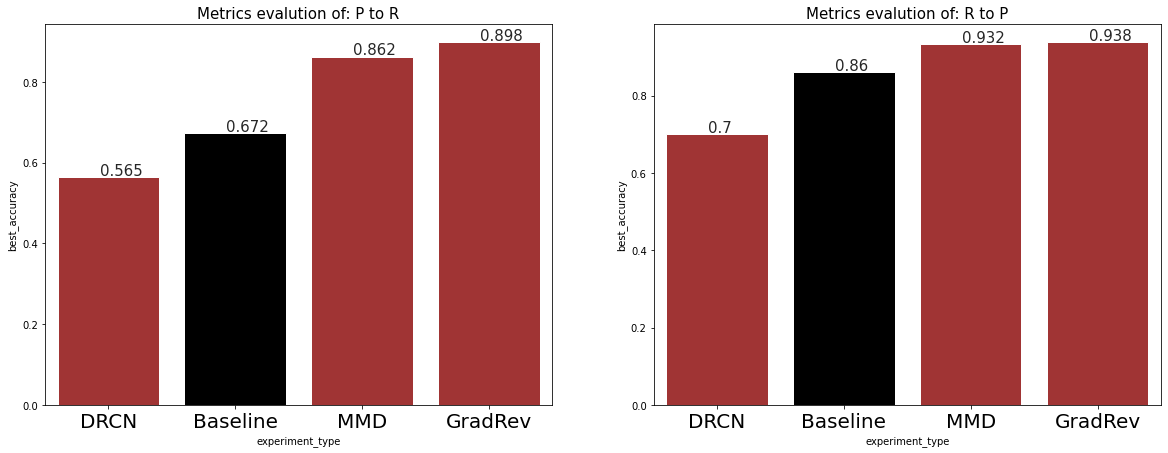

In [25]:
direction_p_to_r = 'P to R'
df_runs_p_to_r = create_pandas_from_wandb(runs, direction = direction_p_to_r)
best_p_to_r = df_runs_p_to_r.groupby('experiment_type').max().sort_values('best_accuracy').reset_index()
sorted_names_p_to_r = best_p_to_r.experiment_type
best_p_to_r['direction'] = direction_p_to_r

direction_r_to_p = 'R to P'
df_runs_r_to_p = create_pandas_from_wandb(runs, direction=direction_r_to_p)
best_r_to_p = df_runs_r_to_p.groupby('experiment_type').max().sort_values('best_accuracy').reset_index()
sorted_names_r_to_p = best_r_to_p.experiment_type
best_r_to_p['direction'] = direction_r_to_p

fig, axes = plt.subplots(1, 2, figsize=(20,7))
sns.set_style('whitegrid')

sns.barplot(
    data = best_p_to_r,
    x = 'experiment_type',
    y = 'best_accuracy',
    palette = ['firebrick' if (name != 'Baseline') else ('black') for name in sorted_names_p_to_r],
    ax = axes[0],
)

sns.barplot(
    data = best_r_to_p,
    x = 'experiment_type',
    y = 'best_accuracy',
    palette = ['firebrick' if (name != 'Baseline') else ('black') for name in sorted_names_r_to_p],
    ax = axes[1],
)

show_values_on_bars(axes, space_x = -0.07, space_y=.005, fontdict=dict(size=15), round_to=3)
axes[0].set_xticklabels(sorted_names_p_to_r.values, fontsize=20)
axes[1].set_xticklabels(sorted_names_r_to_p.values, fontsize=20)
axes[0].set_title(f'Metrics evalution of: {direction_p_to_r}', fontdict=dict(size=15))
axes[1].set_title(f'Metrics evalution of: {direction_r_to_p}', fontdict=dict(size=15))

plt.show()

From the plots above we can understand that MMD method and the gradient reversal layer out perform the baseline in both the direction, from real to product and from product to real while using the DRCN we were not able to obtain better results.

Having an extensive look at all the runs (below) we can better appreciate the difference between the `experiment_type` and the results.

In [26]:
import plotly.express as px

fig = px.bar(df_runs_p_to_r.dropna(subset=['best_accuracy']).reset_index(), 
             x="id", 
             y='best_accuracy', 
             color="experiment_type", 
             title="All experiments from Product to Real")

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=.5
))

fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

In [27]:
fig = px.bar(df_runs_r_to_p.dropna(subset=['best_accuracy']).reset_index(), 
             x="id", 
             y='best_accuracy', 
             color="experiment_type", 
             title="All experiments from Real to Product")

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=.5
))

fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

The learning curves and others details are present in the  <a href="https://wandb.ai/ggabry/UDA">wandb dashboard</a>.

In [28]:
# better experiments in term of best_accuracy
pd.concat(
    [best_p_to_r, best_r_to_p]
)

,experiment_type,id,name,best_test_loss,best_accuracy,tags,direction
0,DRCN,iu0vm7e9,DCRN_v8,0.129780,0.5650,"[DRCN, P to R, good rec]",P to R
1,Baseline,qddg7bi7,freezed_backbone,0.020506,0.6725,"[P to R, baseline, freezed_backbone]",P to R
2,MMD,74yi63jc,mmd_v2,0.187281,0.8625,"[P to R, mmd, multiscale]",P to R
3,GradRev,dvnlij7e,grad_rev_v2,0.025139,0.8975,"[GradRev, P to R, rev_init]",P to R
0,DRCN,3mxiexgp,DCRN_v13_continued,0.090750,0.7000,"[DRCN, R to P]",R to P
1,Baseline,2oimnb8t,baseline_v1,0.008996,0.8600,"[R to P, baseline]",R to P
2,MMD,3dbgsd7g,mmd_v1,0.092483,0.9325,"[R to P, mmd, multiscale]",R to P
3,GradRev,36womikc,grad_rev_v0,0.008012,0.9375,"[GradRev, R to P]",R to P


## &nbsp; 7.1 Reconstructed images

Using DRCN we tried different approaches. We started using as a BackBone a resnet50 but at the first attemps we were not able to reconstruct the images properly; We made different experiments and tried many path at the end we tried to replace the backbone from a resnet to a completly new feature extractor and use a decoder that exactly mirror it.

Doing this operation we were able to reconstruct the images (as shown below) but the metrics regarding the classification task are decreased (compare to having a resnet50 pretrained as a backbone).

In [29]:
run_good_rec_resnet = [run for run in runs if run.id == '1ltykwxp'][0]
run_good_rec_scratch = [run for run in runs if run.id == '3mxiexgp'][0]

Image recreating with ResNet as a backbone:


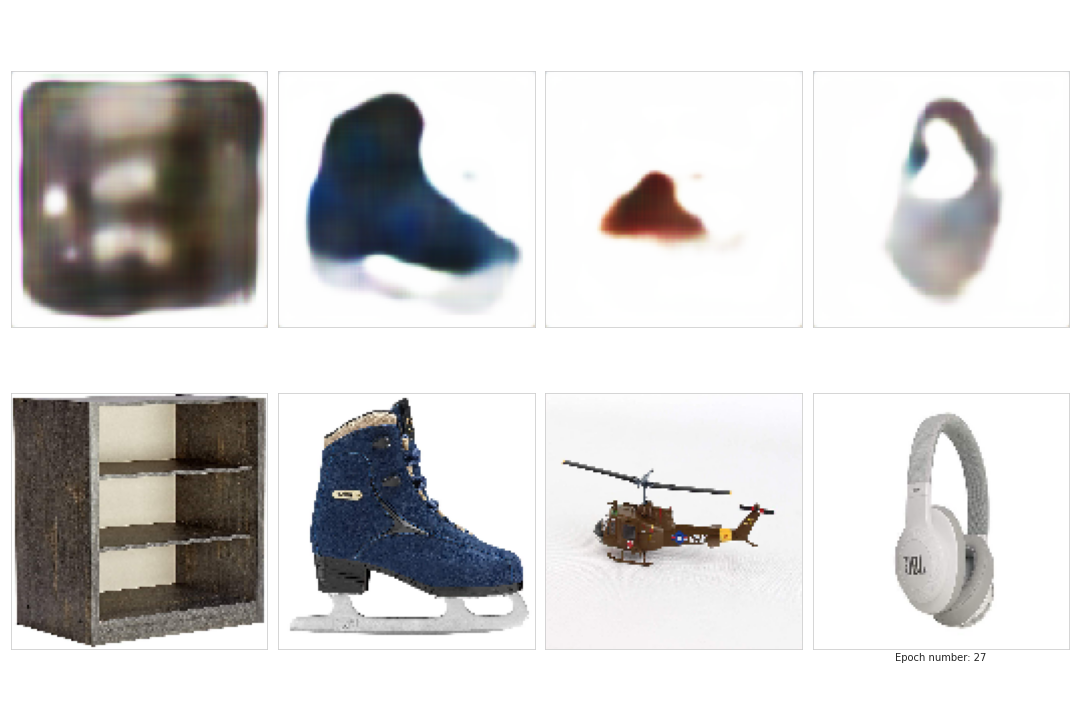

In [47]:
from io import BytesIO
from PIL import Image
import requests

im_scratch_path = "https://raw.githubusercontent.com/GabrieleGhisleni/Unsupervised-domain-adaptation/master/images/30_scrach.png"
im_resnet_path = "https://raw.githubusercontent.com/GabrieleGhisleni/Unsupervised-domain-adaptation/master/images/53_resnet.png"

im_resnet = Image.open(BytesIO(requests.get(im_resnet_path).content))
im_scratch = Image.open(BytesIO(requests.get(im_scratch_path).content))

print('Image recreating with ResNet as a backbone:')
display(im_resnet)

Image recreating with a conv net trained from scratch as a backbone:


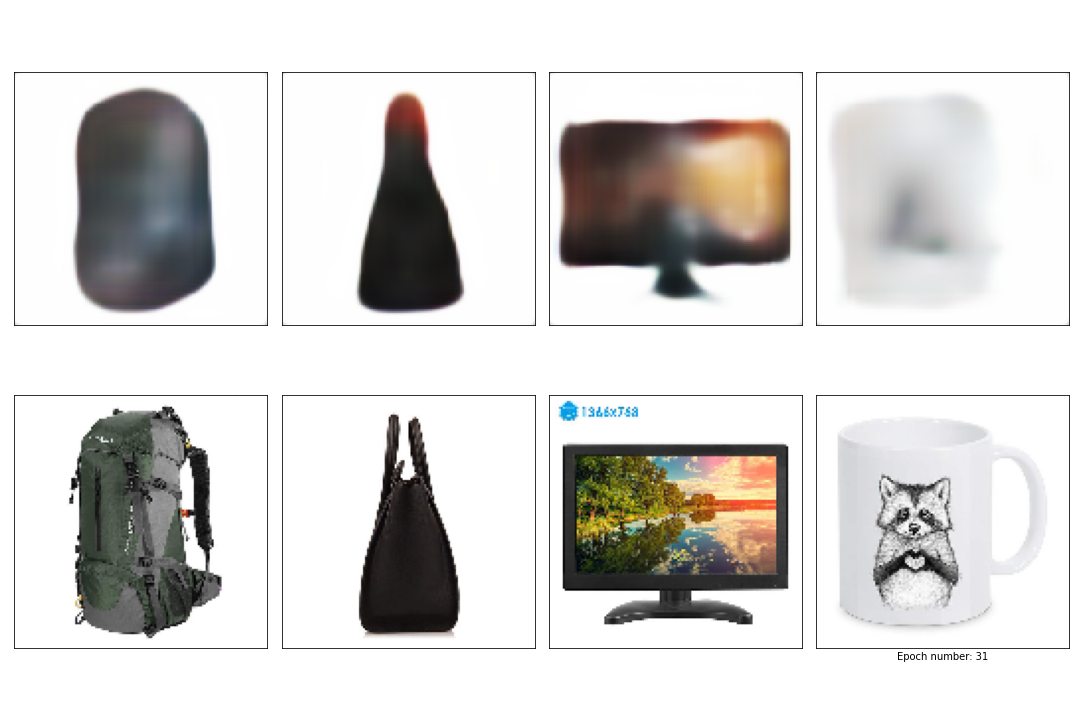

In [48]:
print('Image recreating with a conv net trained from scratch as a backbone:')
display(im_scratch)

# &nbsp; 8 Utils

In [38]:
# download the utils.py file
%%capture
if "utils.py" not in os.listdir():
  url_utils = "https://raw.githubusercontent.com/GabrieleGhisleni/Unsupervised-domain-adaptation/master/src/utils.py"
  !wget --no-cache --backups=1 {url_utils}
  assert 'utils.py' in os.listdir(), 'utils.py not present'

In [39]:
!pygmentize utils.py

######### UTILS
from typing import Callable, Tuple
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch import Tensor
from torch import nn
import pandas as pd
import numpy as np
import pprint
import torch
import wandb


def show_values_on_bars(
    axs,
    h_v: str = "v",
    space_x: float = 0.12,
    space_y: float = 0.1,
    fontdict: dict = None,
    round_to: int = 0,
  ) -> None:
    """
    Show the values on the bar
    Parameters:
        axs: matplotlib axes with the barplot already displayed.
        h_v: str (v) = vertical or 'h' bars.
        space_x: float (0.) = adjust the values of bar x position
        space_y: float (0.) = adjust the values of bar y position
        fontdict: dict = dict for adjust the font of the values.
        round_to: int = round to N decimal (0 for int).

    Return:
        None
    """

    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_wid

# &nbsp; 9 Helper dataset

1. Add a shortcut of the whole Adaptiope dataset into the current folder directory.

[Adaptiote orignal dataset](https://drive.google.com/file/d/1FmdsvetC0oVyrFJ9ER7fcN-cXPOWx2gq/view)


In [40]:
import shutil, os, tqdm
assert 'Adaptiope.zip' in os.listdir(), f'Add the shortcut here: {os.getcwd()}'

In [41]:
%%capture
if 'adaptiope_small' not in os.listdir():
  !unzip Adaptiope.zip # unzip dataset
  !rm -rf adaptiope_small # remove preivous
  !mkdir adaptiope_small # create new folder

In [44]:
classes = [
           "backpack", 
           "bookcase", 
           "car jack", 
           "comb", 
           "crown", 
           "file cabinet", 
           "flat iron", 
           "game controller",
           "glasses", 
           "helicopter",
           "ice skates", 
           "letter tray", 
           "monitor", 
           "mug", 
           "network switch", 
           "over-ear headphones", 
           "pen",
           "purse", 
           "stand mixer", 
           "stroller"
          ]


domain_from_all_df = ["Adaptiope/product_images", "Adaptiope/real_life"]
domain_sub_df = ["adaptiope_small/product_images", "adaptiope_small/real_life"]

if 'adaptiope_small' not in os.listdir():
  for domain, target_domain in zip(domain_from_all_df, domain_sub_df):
    os.makedirs(target_domain, exist_ok=True)
    for class_ in (classes):
      shutil.copytree(
          os.path.join(domain, class_),  
          os.path.join(target_domain, class_)
        )